# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [11]:
% matplotlib inline
# Get the list of columns that were from a survey of parentes, teachers, students
# This is just to see what they are. Going to calculate some correlations
print(survey_fields)

['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_10', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


# Correlations between SAT Score and Survey Data

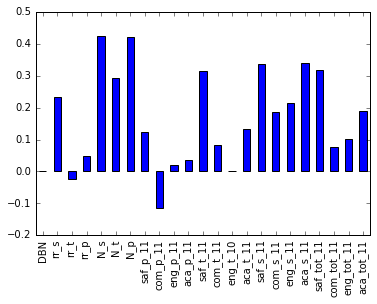

In [12]:
combined.corr()["sat_score"][survey_fields].plot.bar()

## Summary

The highest correlations are between SAT scores and N_s and N_p. These columns correspond to are the number of students, and the number of parent respondents. As such, these are not particularly meaningful correlations.

Aside from this, correlations worth noting are with saf_t_11, saf_s_11, aca_s_11, and saf_tot_11. These columns correspond (respectively) to safety and respect as rated by teachers, safety and respect as rated by students, academic expectations as rated by students, and total safety and respect score.

The one that stands out the most to me is the academic expectations correlation. This ties directly into psychological research on social expectations - when teachers expect students to do well, they give them more attention and resources, and they do better.

# Digging into Safety Scores

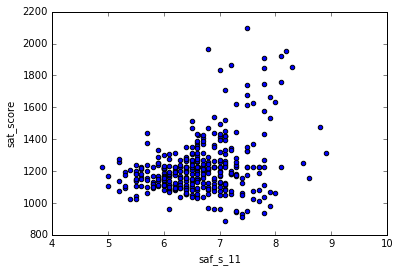

In [13]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

While the correlation between student rated safety and SAT score is decent, about .35, the scatter reveals that the relationship is quite meh. This correlation is likely being driven up artificially by the slew of schools rated as very safe (over 7). Could just be a restricted range problem - would be nice to see SAT scores of more schools in the 8-10 range of student-rated safety.

In [14]:
# Getting the average student-rated safety score by district
# This makes a little dataset for us of all the vars averaged over school district
avg_safety = combined.groupby('school_dist').agg(numpy.mean)
avg_safety.reset_index(inplace=True)

TypeError: fillcontinents() got an unexpected keyword argument 'Lake_color'

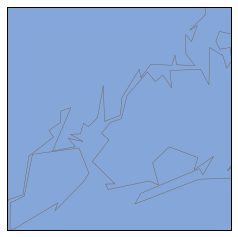

In [15]:
# Mapping the average safety scores over a geo map of NYC
# Make the base of the map. Centered on NYC
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution="i"
)
# Get boundaries, coastlines, and rivers.
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white', Lake_color='#85A6D9')

# Get longitudes and latitudes as a list
longitudes = avg_safety['lon'].tolist()
latitudes = avg_safety['lat'].tolist()

# Map it out!
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=avg_safety['saf_s_11'], cmap='summer')


The deeper green a school district, the safer the students rated the schools on average. Note that Brooklyn has, on average, quite high safety ratings - there is a lot of deep green. On the other hand, in upper Manhattan and the Bronx, the districts are a lot softer green or stronger yellow - indicative of lower ratings of safety.

# Racial Differences

In [ ]:
# Make some bar plots of the relationship between the race percentage cats and sat score
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()["sat_score"][race_cols].plot.bar()

Exactly as you might expect there are quite strong positive correlations. Being White (r ~ .65) or Asian (r ~ .58) are correlated quite strongly with having higher SAT scores. On the other, again completely expected, hand being Black (r ~ -.30) or Hispanic (r ~ -.40) are correlated quite strongly with having lower SAT scores.

In [ ]:
# Scatter plot of the percentage of the school thats hispanic and SAT score
combined.plot.scatter(x='hispanic_per', y='sat_score')

Again, this really seems to be another relationship driven strongly by a handful of outliers. While there are many schools about 20% hispanic with very high SAT scores, there are many (more) schools with the same proportion of hispanic people with low SAT scores. Not particularly informative. 

If you remove the schools that are SAT outliers (avg score above ~ 1,500) there is only a very small downward trend.

In [16]:
# Let's look at schools that are over 95% Hispanic
hispanic_over_95 = combined[combined['hispanic_per'] > 95]
print(hispanic_over_95['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These are the schools that are over 95% Hispanic. When we do a quick google search, we see that most of these schools are geared at new immigrants. Thus, likely a high percentage of students are ESL. This would explain lower SAT scores.

In [17]:
# Lets do the same for schools below 10% Hispanice
hispanic_under_10 = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]
print(hispanic_under_10['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These are the schools with low hispanic enrollment, and high SAT scores. They are technical schools that recieve extra funding, and students can only be admitted if they pass an entrance exam. This explains why students have high SAT scores.

# Gender and SAT Score

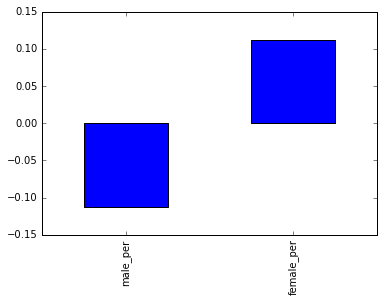

In [18]:
genders = ['male_per', 'female_per']
combined.corr()["sat_score"][genders].plot.bar()

These are obviously the inverse of each other because the two gender columns sum to 100. But what we see is that schools that are more predominantly female score higher on the SATs, on average. How does this actually look on a scatter?

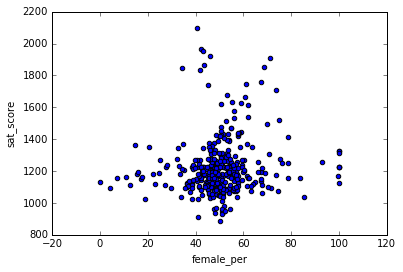

In [19]:
# Plotting the female side
combined.plot.scatter(x='female_per', y='sat_score')

Same interpretation as the others. The relationship looks lackluster when mapped out in a scatter plot. Most schools hover around the 50% range, as one would expect given the law of large numbers. Looking at this, I would conclude there is no relationship between the average proportion of females and average SAT score of a school.

In [20]:
# Let's take a quick look at schools with more than 60% females and high SATs
high_females = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
print(high_females['SCHOOL NAME'])


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Just a couple of schools. A quick google search demonstrates that these schools are very selective liberal arts schools with extremely high academic standards.

# AP Schools

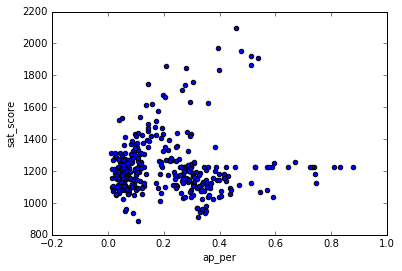

In [21]:
# What proportion of students per school took AP exams?
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

# Scatter it out!
combined.plot.scatter(x='ap_per', y='sat_score')

This one is kind of interesting. Let's look at it the other way to better see the nature of the somewhat curvilinear relationship.

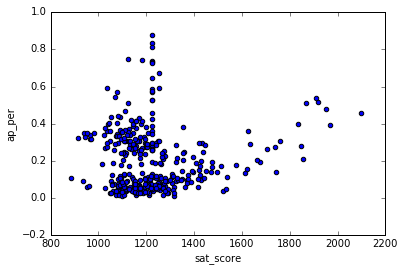

In [22]:
combined.plot.scatter(x='sat_score', y='ap_per')

It seems like there are a slew of schools that had more than 60% of their students take AP exams, but saw no increases in average SAT scores. There is, however, a batch of schools that had relatively few students take AP exams (less than 60%) with very high SAT scores.

# Average Class Size

In [23]:
# correlation between class size and sat score
combined.corr()['sat_score']['AVERAGE CLASS SIZE']

0.38101433080955233

This is somewhat interesting as I would have expected a negative correlation here.

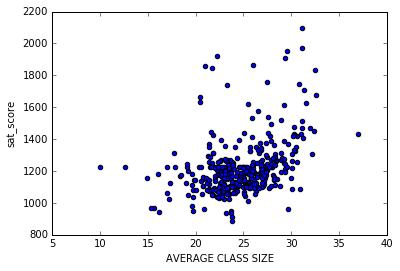

In [55]:
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')

Interesting, because we might expect SAT scores to go down when class sizes go up because this is usually indicative of underfunded, overstaffed schools in lower socioeconomic status areas. However, it seems here that the relationship is positive. Relationship is really getting pulled up by just a few schools with high SAT scores and over 25 kids per class.

In [57]:
# class size above 25, and high SAT scores (over 1600)
big_class = combined[(combined['AVERAGE CLASS SIZE'] > 25) & (combined['sat_score'] > 1600)]
print(big_class['SCHOOL NAME'])

4      NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...
24           N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
278       LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Again, this makes sense. A wikipedia search of some of the above schools shows that they are extremly competitive. For example, Millenium High School received 6,000 applications for just 170 spots for students, the NYC Lab School requires entrance exams, etc. These are all extremely competitive schools.

# Short Summary

What all of these analyses suggest to me is that the SAT is possibly not particularly race biased, but is biased on socioeconomic status (SES). Now, I recognize that race and SES are highly conflated, so these two things would need to be untangled. I could do this if I had average parent income for the schools, or average neighbourhood income/property value by NYC school district. 

There are various complications with low income that may affect students SAT scores. The biggest one that comes to mind for me is cognitive deficits as a result of malnutrition (Shafir, 2013). If students cannot properly fuel they are not able to perform adequately. This becomes a larger, again more race-relevant issue, if we pull back and look at the demographics of low SES people in NYC.

Thus, I think this is a race issue insofar as the SAT is biased against kids who are growing up in low income households and being sent to poor schools in low income districts, which happens to be predominantly minority children.

In [1]:
print(data['hs_directory'].head())

NameError: name 'data' is not defined